<a href="https://colab.research.google.com/github/SamuelSS09/face-mask-detection-projet-s9/blob/main/Test_MobilNetV2_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source 1 : https://github.com/HOD101s/Face-Mask-Detection

Source 2 : https://github.com/mk-gurucharan/Face-Mask-Detection

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil

from shutil import copyfile

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D, GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


Fetching Our Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip "/content/drive/My Drive/PROJET S9/Classification/Codes/Datasets/Simulated_dataset.zip" -d "/content/"
# !tar -xvf  "/content/drive/My Drive/PROJET S9/Classification/Codes/Datasets/Simulated_dataset.zip" -C "content/"
!unzip "/content/drive/My Drive/PROJET S9/Classification/Codes/Datasets/n_dataset.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/n_dataset/no_mask/2138.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._2138.png  
  inflating: /content/n_dataset/no_mask/3226.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._3226.png  
  inflating: /content/n_dataset/no_mask/1431.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._1431.png  
  inflating: /content/n_dataset/no_mask/1357.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._1357.png  
  inflating: /content/n_dataset/no_mask/0049.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._0049.png  
  inflating: /content/n_dataset/no_mask/2886.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._2886.png  
  inflating: /content/n_dataset/no_mask/2892.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._2892.png  
  inflating: /content/n_dataset/no_mask/1343.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._1343.png  
  inflating: /content/n_dataset/no_mask/1425.

In [ ]:
base = ''

DATAPATH = os.path.join(base,'n_dataset/')
MASKPATH = os.path.join(,'mask/')
NOMASKPATH = os.path.join(DATAPATH,'no_mask/')
DATAPATH
TRAINPATH = os.path.join(DATAPATH,'traindata/')
TRAIN_MASK_PATH = os.path.join(DATAPATH,'traindata/mask/')
TRAIN_NOMASK_PATH = os.path.join(DATAPATH,'traindata/no_mask/')

VALPATH = os.path.join(DATAPATH,'valdata/')
VAL_MASK_PATH = os.path.join(DATAPATH,'valdata/mask/')
VAL_NOMASK_PATH = os.path.join(DATAPATH,'valdata/no_mask/')

# TESTPATH = os.path.join(base,'our_dataset/testdata/')
# TEST_MASK_PATH = os.path.join(base,'our_dataset/testdata/mask/')
# TEST_NOMASK_PATH = os.path.join(base,'our_dataset/testdata/no_mask/')

WEIGHTS_PATH = os.path.join(base,'weights/')
os.makedirs(WEIGHTS_PATH,exist_ok = True)
WEIGHTS_FILE = os.path.join(WEIGHTS_PATH,'MobileNetV2_V2.h5')

Visualizing our data

In [ ]:
def view(pth):
    images = list()
    for img in random.sample(os.listdir(pth),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(pth,images[i])))
            i+=1

In [ ]:
NumberMaskData = os.listdir(MASKPATH)
print(len(NumberMaskData))

1655


In [ ]:
NumberNOMaskData = os.listdir(NOMASKPATH)
print(len(NumberNOMaskData))

3265


In [ ]:
# view(MASKPATH)

In [ ]:
# view(NOMASKPATH)

Analysing our Data

In [ ]:
fig = go.Figure(
    data=[go.Pie(labels=['WITHMASK','WITHOUTMASK'], 
        values=[len(os.listdir(MASKPATH)),len(os.listdir(NOMASKPATH))])
    ])
fig.show()

Splitting Training Test

We have

NO MASK : 2,736 items

WITH MASK : 3,000 items

So now we split data into train test sets. We'll take around 2% data for testing purposes.

In [ ]:
os.makedirs(TRAINPATH, exist_ok=True)
os.makedirs(os.path.join(TRAINPATH,'mask'), exist_ok=True)
os.makedirs(os.path.join(TRAINPATH,'no_mask'), exist_ok=True)

os.makedirs(VALPATH, exist_ok=True)
os.makedirs(os.path.join(VALPATH,'mask'), exist_ok=True)
os.makedirs(os.path.join(VALPATH,'no_mask'), exist_ok=True)

# os.makedirs(TESTPATH, exist_ok=True)
# os.makedirs(os.path.join(TESTPATH,'mask'), exist_ok=True)
# os.makedirs(os.path.join(TESTPATH,'no_mask'), exist_ok=True)

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset = []
    
    for unitData in os.listdir(SOURCE):
        data = SOURCE + unitData
        if(os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = SOURCE + unitData
        final_train_set = TRAINING + unitData
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = SOURCE + unitData
        final_test_set = TESTING + unitData
        copyfile(temp_test_set, final_test_set)


In [ ]:
from pathlib import Path

[f.unlink() for f in Path(TRAIN_MASK_PATH).glob("*") if f.is_file()] 
[f.unlink() for f in Path(TRAIN_NOMASK_PATH).glob("*") if f.is_file()] 

# [f.unlink() for f in Path(TEST_MASK_PATH).glob("*") if f.is_file()] 
# [f.unlink() for f in Path(TEST_NOMASK_PATH).glob("*") if f.is_file()] 

[f.unlink() for f in Path(VAL_MASK_PATH).glob("*") if f.is_file()] 
[f.unlink() for f in Path(VAL_NOMASK_PATH).glob("*") if f.is_file()] 

print("The training set mask/no_mask sizes: (",len(os.listdir(TRAIN_MASK_PATH)),",",len(os.listdir(TRAIN_NOMASK_PATH)),")")
print("The test set mask/no_mask sizes: (",len(os.listdir(VAL_MASK_PATH)),",",len(os.listdir(VAL_NOMASK_PATH)),")")
# print("The test set mask/no_mask sizes: (",len(os.listdir(TEST_MASK_PATH)),",",len(os.listdir(TEST_NOMASK_PATH)),")")

The training set mask/no_mask sizes: ( 0 , 0 )
The test set mask/no_mask sizes: ( 0 , 0 )


In [ ]:
split_size = .80
split_data(MASKPATH, TRAIN_MASK_PATH, VAL_MASK_PATH, split_size)
split_data(NOMASKPATH, TRAIN_NOMASK_PATH, VAL_NOMASK_PATH, split_size)

In [ ]:
print("The number of images with facemask in the training set:", len(os.listdir(TRAIN_MASK_PATH)))
print("The number of images without facemask in the training set:", len(os.listdir(TRAIN_NOMASK_PATH)))
print("The number of images with facemask in the test set:", len(os.listdir(VAL_MASK_PATH)))
print("The number of images without facemask in the test set:", len(os.listdir(VAL_NOMASK_PATH)))


The number of images with facemask in the training set: 1324
The number of images without facemask in the training set: 2612
The number of images with facemask in the test set: 331
The number of images without facemask in the test set: 653


Preparing Data Input Pipelines

In [ ]:
BATCH_SIZE = 32
EPOCHS = 75

In [ ]:
trainGen = ImageDataGenerator(rescale=1.0/255.0,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

testGen = ImageDataGenerator(
    rescale= 1.0/255.0,
)

Ref : https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [ ]:
train = trainGen.flow_from_directory(
    TRAINPATH, 
    target_size=(224, 224),
    classes=['mask','no_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)

validation = testGen.flow_from_directory(
    VALPATH, 
    target_size=(224, 224),
    classes=['mask','no_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)


Found 3935 images belonging to 2 classes.
Found 984 images belonging to 2 classes.


In [ ]:
# merci: https://yann-leguilly.gitlab.io/post/2019-10-09-tensorflow-tfdata/

train_ds = tf.data.Dataset.from_generator(lambda: train,
                     output_types=(tf.float32, tf.float32),
                     output_shapes=([BATCH_SIZE, 224, 224, 3],
                                    [BATCH_SIZE, 2])
                     )

valid_ds = tf.data.Dataset.from_generator(lambda: validation,
                     output_types=(tf.float32, tf.float32),
                     output_shapes=([1, 224, 224, 3],
                                    [1, 2])
                     )

Model Building

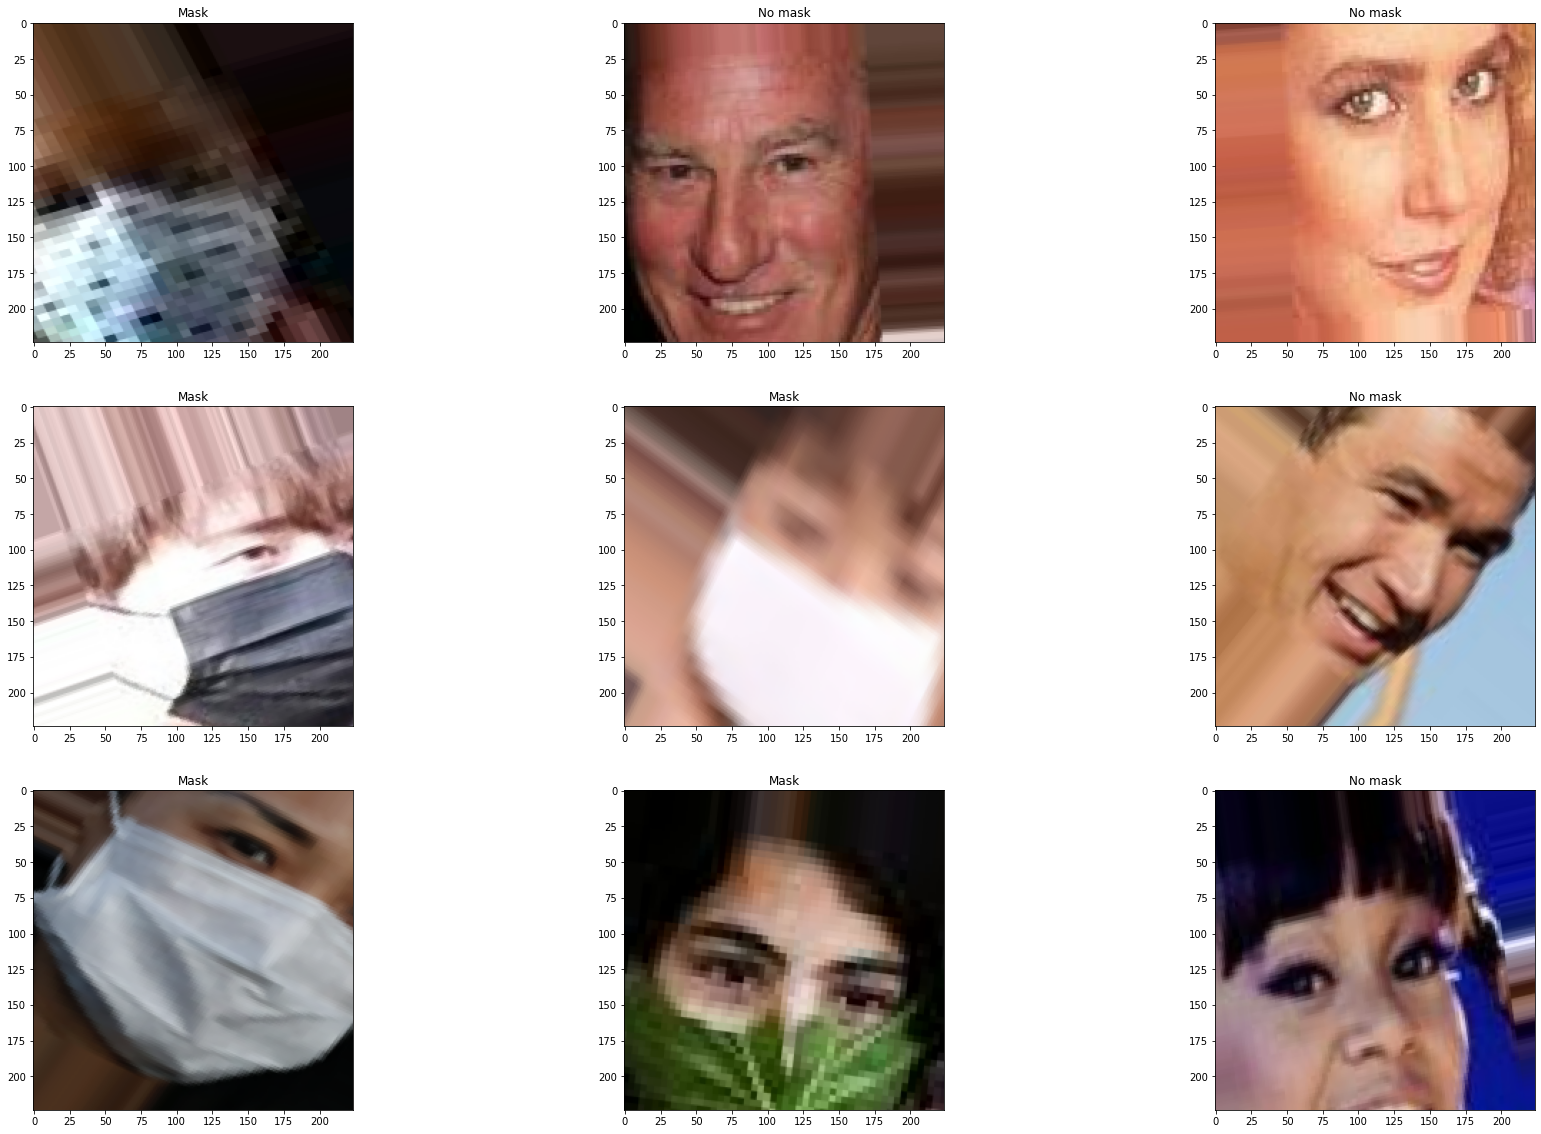

In [ ]:
imgs = list()
classes = list()
for i,c in train_ds.take(9):
    imgs.append(np.array(i[0]))
    classes.append(np.array(c[0]))

    
fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
i=0
for row in range(3):
    for col in range(3):
        ax[row,col].imshow(imgs[i])
        ax[row,col].title.set_text('Mask' if classes[i][0] == 1.0 else 'No mask')
        i+=1
# plt.close()

In [ ]:
mob = MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet',
)
mob.trainable = False


TRANSFER TRAINING

In [ ]:
model = Sequential()
model.add(mob)
model.add(GlobalMaxPool2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 2,340,098
Trainable params: 82,114
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# checkpoint_filepath3 = "/content/drive/My Drive/PROJET S9/Classification/Codes/check_points3"

checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)


Ref : https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', 
                                patience=3, 
                                min_delta=0.001, 
                                mode='max')
# while monitoring val_accuraccy model achieve 1.00 result at 17 epochs

Ref : https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/

In [ ]:
STEP_SIZE_TRAIN=train.n//train.batch_size
STEP_SIZE_VALID=validation.n//validation.batch_size

print("Steps in training set:", STEP_SIZE_TRAIN)
print("Steps in validation set:", STEP_SIZE_VALID)

Steps in training set: 122
Steps in validation set: 30


In [ ]:
history = model.fit_generator(generator=train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    callbacks = [checkpoint]
)

# loss: 0.0112 - accuracy: 0.9958 - val_loss: 0.0110 - val_accuracy: 0.9973 for 15 epochs our dataset
# loss: 0.0093 - accuracy: 0.9982 - val_loss: 6.9978e-04 - val_accuracy: 1.0000 for 17 epochs our dataset
# loss: 0.0072 - accuracy: 0.9971 - val_loss: 0.0161 - val_accuracy: 0.9964 for 20 epochs our dataset

# loss: 0.0140 - accuracy: 0.9969 - val_loss: 0.0892 - val_accuracy: 0.9688 for 15 epochs simulated dataset

# loss: 0.0639 - accuracy: 0.9754 - val_loss: 0.0445 - val_accuracy: 0.9833 for 15 epochs n_dataset
# loss: 0.0588 - accuracy: 0.9777 - val_loss: 0.0343 - val_accuracy: 0.9875 for 20 epochs n_dataset
# loss: 0.0452 - accuracy: 0.9828 - val_loss: 0.0339 - val_accuracy: 0.9865 for 50 epochs n_dataset
# loss: 0.0327 - accuracy: 0.9885 - val_loss: 0.0534 - val_accuracy: 0.9854 for 75 epochs n_dataset, variations very instable

Epoch 1/75
122/122 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9836
Epoch 00001: val_loss did not improve from 0.02254
122/122 [==============================] - 42s 347ms/step - loss: 0.0444 - accuracy: 0.9836 - val_loss: 0.0354 - val_accuracy: 0.9885
Epoch 2/75
122/122 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9821
Epoch 00002: val_loss did not improve from 0.02254
122/122 [==============================] - 42s 345ms/step - loss: 0.0541 - accuracy: 0.9821 - val_loss: 0.0336 - val_accuracy: 0.9885
Epoch 3/75
122/122 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9867
Epoch 00003: val_loss did not improve from 0.02254
122/122 [==============================] - 42s 345ms/step - loss: 0.0447 - accuracy: 0.9867 - val_loss: 0.0816 - val_accuracy: 0.9802
Epoch 4/75
122/122 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9833
Epoch 00004: val_loss did not improve from 0.02254
122/122 [=

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.save_weights(WEIGHTS_FILE)
#model.load_weights(checkpoint_filepath2)

In [ ]:
model.evaluate_generator(generator=validation, steps=STEP_SIZE_VALID)

[0.05327414348721504, 0.9854166507720947]

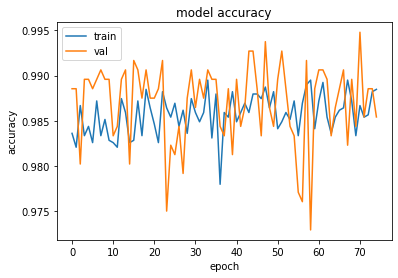

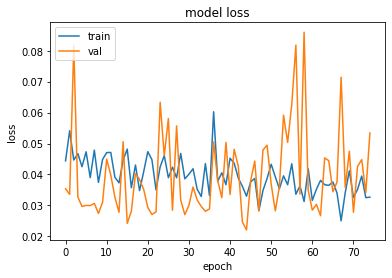

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Points to check : https://cs231n.github.io/neural-networks-3/#sanitycheck

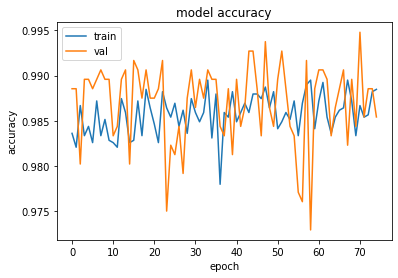

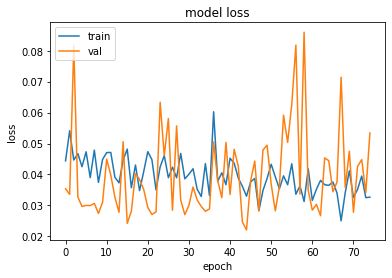

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NOTES:

- Tester les codes sur 10 images (e.g) pour voir si le code marche bien
- Voir la sortie de MobileNetV2
- Le CNN doit voir si la partie basse de l'image est dense
- Peut etre ajouter un 3eme set de validation (pour le moment on a train et test)
- Entrainer sur moins d'images au depart
- Comment mesurer la vitesse d'execution du code??
